In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from fydyc_dataset import FydycDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
class PolynomialRegression(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        # 计算两个变量的多项式特征数量（包括交叉项和常数项）
        num_features = (degree + 1) * (degree + 2) // 2
        self.linear = nn.Linear(num_features, 1)
    
    def forward(self, x):
        # x应该是一个二维张量，其中x[:, 0]是x1，x[:, 1]是x2
        poly_features = []
        for i in range(self.degree + 1):
            for j in range(self.degree + 1 - i):
                # 通过使用unsqueeze方法增加一个维度，确保每个特征都是二维的
                poly_feature = (x[:, 0] ** i * x[:, 1] ** j).unsqueeze(1)
                poly_features.append(poly_feature)
        poly_features = torch.cat(poly_features, dim=1)
        return self.linear(poly_features)

        
degree = 3  # 二次多项式
model = PolynomialRegression(degree)
model.load_state_dict(torch.load('fydyc/1000epoch-供电-多项式回归-3次.pth'))
dataset = FydycDataset(csv_file='fydyc/供电.csv')
csv_file = 'fydyc/供电_valid.csv'
data = pd.read_csv(csv_file)


      间隔天数         预测值         实际值
0        5  13890.8701  10863.7178
1        2  13932.8223  10863.7178
2        3  14048.3750  10863.7178
3        4  13601.4951  10863.7178
4        6  14201.8711  10863.7178
...    ...         ...         ...
2120     2  17331.4414  14442.0889
2121     5  16841.3477  14442.0889
2122     6  17427.9922  14442.0889
2123     7  17161.5137  14442.0889
2124     1  17153.4375  14442.0889

[2125 rows x 3 columns]


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_10186/2917801600.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


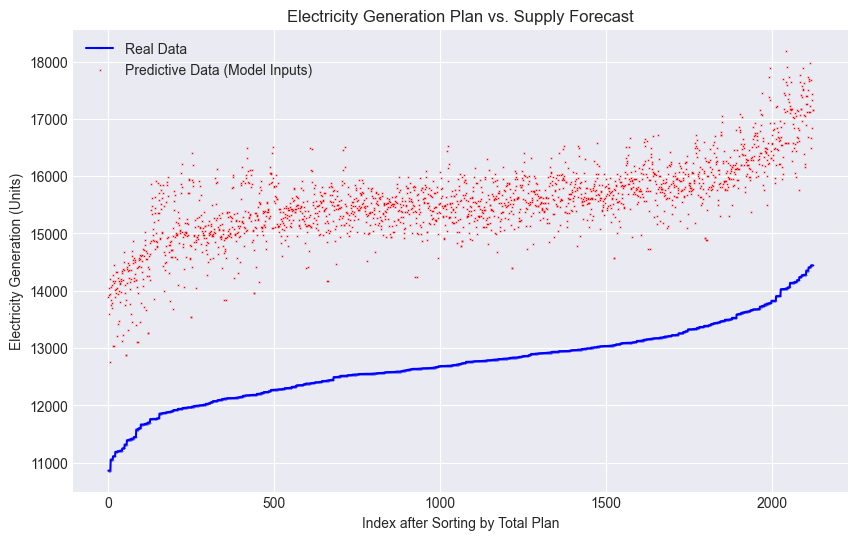

In [2]:
# 按 'total_plan' 进行排序
data_sorted = data.sort_values(by='实际值').reset_index(drop=True)
print(data_sorted)

# 设置matplotlib配置参数以支持中文显示
plt.rcParams['font.family'] = ['Arial Unicode MS']  # MacOS系统可用
# plt.rcParams['font.family'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制 'total_plan' 作为发电量
plt.plot(data_sorted.index, data_sorted['实际值'], label='Real Data', color='blue', marker='o', linestyle='-', markersize=0.1)

# 使用点图绘制 '供电预测' 作为发电量
plt.scatter(data_sorted.index, data_sorted['预测值'], label='Predictive Data (Model Inputs)', color='red', marker='x', s=0.1)  # s 控制点的大小

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Electricity Generation Plan vs. Supply Forecast")
plt.xlabel("Index after Sorting by Total Plan")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_10186/1378998479.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


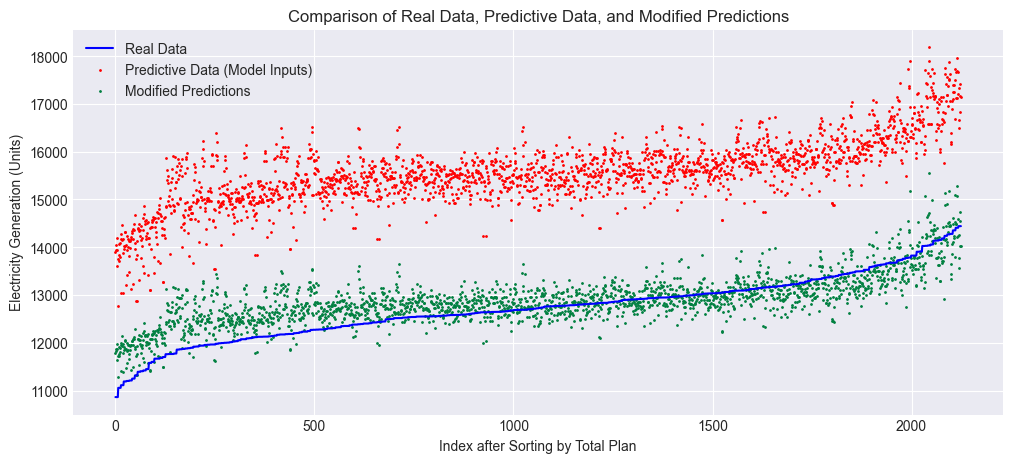

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

    
# 初始化一个列表来存储预测值
predicted_values = []

for index, row in data_sorted.iterrows():
    value1 = row['预测值']
    value2 = row['间隔天数']
    # 将当前值标准化
    if value1 != 0:
        normalized_value = dataset.scaler_features.transform([[value1,value2]])
        input_tensor = torch.from_numpy(normalized_value).float()
        input_tensor = input_tensor.view(1, -1)  # 确保其形状与模型输入的形状相匹配

        # 不需要计算梯度
        with torch.no_grad():
            output_tensor = model(input_tensor) 

        # 将输出张量转换为 numpy 数组并进行逆标准化
        output_value = output_tensor.numpy() 
        predicted_value = dataset.scaler_labels.inverse_transform(output_value)
    else:
        predicted_value = [[0]]
    
    # 将预测值添加到列表中
    predicted_values.append(predicted_value[0][0])
    
# 确保predicted_values_sorted是一个Pandas Series，如果不是，可以通过下面的代码转换
predicted_values = pd.Series(predicted_values)

# 将预测值添加到排序后的DataFrame中
data_sorted['Modified_Predictions'] = predicted_values.values


# 现在，data_sorted已经包含了"Modified Predictions"字段，接下来可以绘图来比较实际数据、预测数据和修正后的预测数据

# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(12, 5))

# 绘制 'total_plan' 作为实际发电量
plt.plot(data_sorted.index, data_sorted['实际值'], label='Real Data', color='blue', linestyle='-')

# 绘制 '供电预测' 作为预测发电量
plt.scatter(data_sorted.index, data_sorted['预测值'], label='Predictive Data (Model Inputs)', color='red', s=1)

# 绘制修正后的预测值
plt.scatter(data_sorted.index, data_sorted['Modified_Predictions'], label='Modified Predictions', color='#008040', s=1)

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Comparison of Real Data, Predictive Data, and Modified Predictions")
plt.xlabel("Index after Sorting by Total Plan")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# 假设 dataset.scaler_labels 已经是一个训练好的 MinMaxScaler 实例
# real_value = np.array([[11436,1]])  # 这一行似乎是多余的，因为它没有在后续代码中使用

# 假设 data_sorted 是你已有的一个DataFrame，包含了'实际值', '预测值', 和 'Modified_Predictions' 列

# 使用 dataset.scaler_labels.transform 对 '实际值' 进行归一化处理
data_sorted['实际值_normalized'] = dataset.scaler_labels.transform(data_sorted[['实际值']])
data_sorted['预测值_normalized'] = dataset.scaler_labels.transform(data_sorted[['预测值']])
data_sorted['Modified_Predictions_normalized'] = dataset.scaler_labels.transform(data_sorted[['Modified_Predictions']])
data_normalized = data_sorted
# 计算归一化后的 '预测值' 与 '实际值' 的 MSE、RMSE 和 MAE
mse_pred = mean_squared_error(data_normalized['实际值_normalized'], data_normalized['预测值_normalized'])
rmse_pred = np.sqrt(mse_pred)
mae_pred = mean_absolute_error(data_normalized['实际值_normalized'], data_normalized['预测值_normalized'])

# 计算归一化后的 'Modified_Predictions' 与 '实际值' 的 MSE、RMSE 和 MAE
mse_mod = mean_squared_error(data_normalized['实际值_normalized'], data_normalized['Modified_Predictions_normalized'])
rmse_mod = np.sqrt(mse_mod)
mae_mod = mean_absolute_error(data_normalized['实际值_normalized'], data_normalized['Modified_Predictions_normalized'])

# 计算差值
mse_diff = mse_pred - mse_mod
rmse_diff = rmse_pred - rmse_mod
mae_diff = mae_pred - mae_mod

# 打印结果
print(f"修正前 MSE: {round(mse_pred, 3)}, RMSE: {round(rmse_pred, 3)}, MAE: {round(mae_pred, 3)}")
print(f"修正后 MSE: {round(mse_mod, 3)} (-{round(mse_diff, 3)}), RMSE: {round(rmse_mod, 3)} (-{round(rmse_diff, 3)}), MAE: {round(mae_mod, 3)} (-{round(mae_diff, 3)})")


修正前 MSE: 0.306, RMSE: 0.553, MAE: 0.547
修正后 MSE: 0.007 (-0.299), RMSE: 0.082 (-0.471), MAE: 0.063 (-0.483)


/Users/mac1234/anaconda3/envs/sql/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/mac1234/anaconda3/envs/sql/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/mac1234/anaconda3/envs/sql/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


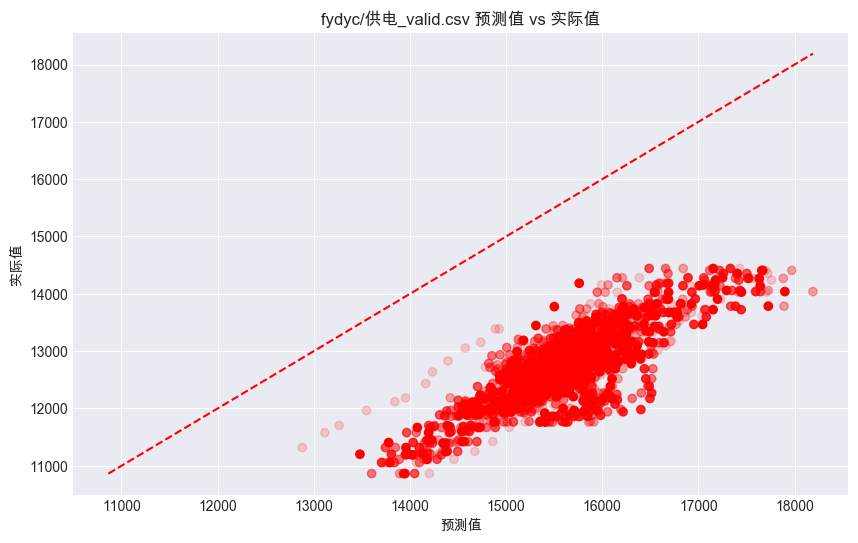

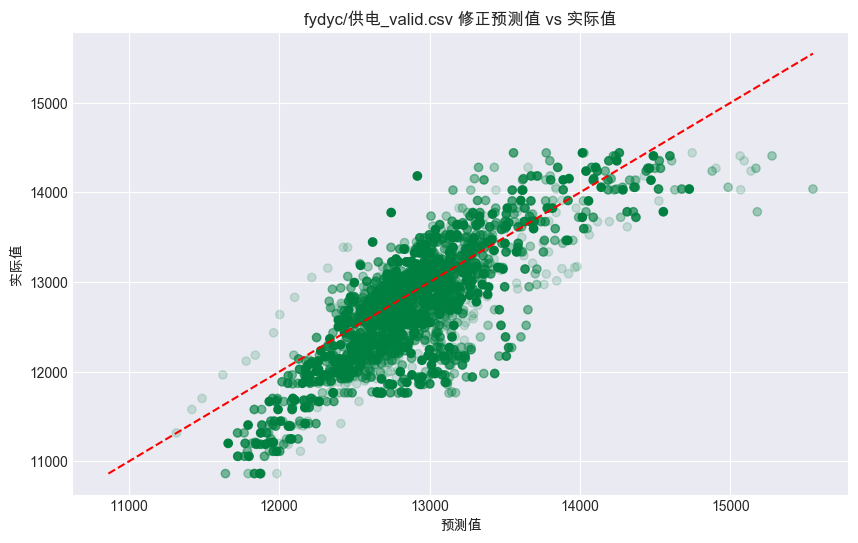

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置matplotlib配置参数以支持中文显示
plt.rcParams['font.family'] = ['Arial Unicode MS']  # MacOS系统可用
# plt.rcParams['font.family'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 定义一个函数来读取数据、处理数据，并绘制预测值与实际值的散点图
def plot_prediction_vs_actual(file_name):
    # 读取CSV文件
    df = pd.read_csv(file_name, dtype=str)

    # 将预测值、实际值和间隔天数转换为数值类型
    df['预测值'] = data_sorted['预测值']
    df['实际值'] = data_sorted['实际值']
    df['间隔天数'] =  data_sorted['间隔天数']

    # 标准化间隔天数到0-1范围，用作点的透明度
    alpha_values = 1 - (df['间隔天数'] - df['间隔天数'].min()) / (df['间隔天数'].max() - df['间隔天数'].min())

    # 绘制预测值与实际值的散点图，透明度随间隔天数增加
    plt.figure(figsize=(10, 6))
    plt.scatter(df['预测值'], df['实际值'], color='red', alpha=alpha_values)

    # 添加图例、标题和轴标签
    plt.title(f'{file_name} 预测值 vs 实际值')
    plt.xlabel('预测值')
    plt.ylabel('实际值')

    # 绘制对角线，表示完美预测的位置
    max_value = max(df['预测值'].max(), df['实际值'].max())
    min_value = min(df['预测值'].min(), df['实际值'].min())
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')

    # 显示图形
    plt.show()
    
def plot_modified_prediction_vs_actual(file_name):
    # 读取CSV文件
    df = pd.read_csv(file_name, dtype=str)

    # 将预测值、实际值和间隔天数转换为数值类型
    df['实际值'] = data_sorted['实际值']
    df['间隔天数'] =  data_sorted['间隔天数']
    df['预测值'] = data_sorted['Modified_Predictions']

    # 标准化间隔天数到0-1范围，用作点的透明度
    alpha_values = 1 - (df['间隔天数'] - df['间隔天数'].min()) / (df['间隔天数'].max() - df['间隔天数'].min())

    # 绘制预测值与实际值的散点图，透明度随间隔天数增加
    plt.figure(figsize=(10, 6))
    plt.scatter(df['预测值'], df['实际值'], color='#008040', alpha=alpha_values)

    # 添加图例、标题和轴标签
    plt.title(f'{file_name} 修正预测值 vs 实际值')
    plt.xlabel('预测值')
    plt.ylabel('实际值')

    # 绘制对角线，表示完美预测的位置
    max_value = max(df['预测值'].max(), df['实际值'].max())
    min_value = min(df['预测值'].min(), df['实际值'].min())
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')

    # 显示图形
    plt.show()


plot_prediction_vs_actual(csv_file)
plot_modified_prediction_vs_actual(csv_file)


In [19]:
import torch
import numpy as np
from datetime import datetime

# 加载模型
modelfl = PolynomialRegression(degree)
modelfl.load_state_dict(torch.load('fydyc/400epoch-风力-多项式回归-3次.pth'))
modelgf = PolynomialRegression(degree)
modelgf.load_state_dict(torch.load('fydyc/1000epoch-光伏-多项式回归-3次.pth'))
modelgd = PolynomialRegression(degree)
modelgd.load_state_dict(torch.load('fydyc/1000epoch-供电-多项式回归-3次.pth'))

models = {'风力': modelfl, '光伏': modelgf, '供电': modelgd}
datas = {'风力': 'fydyc/风力.csv', '光伏': 'fydyc/光伏.csv', '供电': 'fydyc/供电.csv'}

def predict(value, current_date, predict_date, model_name):
    """
    根据输入的预测值、当前日期、预测日期和模型名称进行预测。
    
    参数:
    - value: 预测值（float）
    - current_date: 当前日期（str，格式为'YYYY-MM-DD'）
    - predict_date: 预测日期（str，格式为'YYYY-MM-DD'）
    - model_name: 模型名称（str，可选项为'风力'、'光伏'、'供电'）
    
    返回:
    - 预测结果（float）
    """
    dataset = FydycDataset(csv_file = datas[model_name])
    
    if value == 0:
        return 0.00
    
    # 转换日期格式
    current_date = datetime.strptime(current_date, '%Y%m%d').date()
    predict_date = datetime.strptime(predict_date, '%Y%m%d').date()
    
    # 计算日期差
    date_diff = (predict_date - current_date).days
    
    # 归一化输入
    normalized_input = dataset.scaler_features.transform([[value, date_diff]])
    input_tensor = torch.from_numpy(normalized_input).float()
    
    # 选择模型并进行预测
    selected_model = models[model_name]
    with torch.no_grad():
        output_tensor = selected_model(input_tensor)
    
    # 逆归一化输出值
    output_value = output_tensor.numpy()
    predicted_value = dataset.scaler_labels.inverse_transform(output_value)
    
    return predicted_value[0][0]

# 使用示例
# 需要替换成实际的参数值
predicted_result = predict(15000, '20230308', '20230310', '供电')
print(f'预测结果: {predicted_result}')


预测结果: 12428.34765625
